In [1]:
!pip3 install beautifulsoup4
!pip3 install requests

In [2]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

In [3]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


In [4]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

In [5]:
# Request the Falcon9 Launch Wiki page from its URL
# use requests.get() method with the provided static_url and headers
# assign the response to an object
html_response = requests.get(static_url, headers=headers)

# Create a BeautifulSoup object from the HTML response
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(html_response.text, 'html.parser')

# Print the page title to verify if the BeautifulSoup object was created properly
# Use soup.title attribute
print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [6]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')

# Starting from the third table is our target table contains the actual launch records.

# Let's print the third table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and le
for th in first_launch_table.find_all('th'):
    name = extract_column_from_header(th)
    if name is not None and len(name) > 0:
        column_names.append(name)

print(column_names)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 

In [7]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element
        row=rows.find_all('td')
        #if it is number save cells in a dictonary
        if flag:
            extracted_row += 1
            # Flight Number value
            # Append the flight number
            launch_dict['Flight No.'].append(flight_number)

            datatimelist = date_time(row[0])
            # Date value
            # Append the date
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)

            # Time value
            # Append the time
            time = datatimelist[1]
            launch_dict['Time'].append(time)

            # Booster version
            # Append the booster version
            bv = booster_version(row[1])
            if not bv:
                bv = row[1].a.string if row[1].a else ''
            launch_dict['Version Booster'].append(bv)

            # Launch Site
            # Append the launch site
            launch_site = row[2].a.string if row[2].a else ''
            launch_dict['Launch site'].append(launch_site)

            # Payload
            # Append the payload
            payload = row[3].a.string if row[3].a else ''
            launch_dict['Payload'].append(payload)

            # Payload Mass
            # Append the payload mass
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)

            # Orbit
            # Append the orbit
            orbit = row[5].a.string if row[5].a else ''
            launch_dict['Orbit'].append(orbit)

            # Customer
            # Append the customer
            customer = row[6].a.string if row[6].a else ''
            launch_dict['Customer'].append(customer)

            # Launch outcome
            # Append the launch outcome
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)

            # Booster landing
            # Append the booster landing status
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

In [8]:
df = pd.DataFrame.from_dict(launch_dict)
display(df.head())

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10


# Task
Clean the 'Payload mass' column in the dataframe, convert it to numeric, and then plot the distribution of the 'Payload mass'.

## Clean 'payload mass' column

### Subtask:
Remove 'kg' and commas from the 'Payload mass' column in the dataframe, then convert the column to numeric type.


**Reasoning**:
Clean the 'Payload mass' column by removing 'kg' and commas, convert it to numeric, and handle errors.



In [9]:
df['Payload mass'] = df['Payload mass'].str.replace('kg', '').str.replace(',', '')
df['Payload mass'] = pd.to_numeric(df['Payload mass'], errors='coerce')
display(df.head())

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,NaN,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525.0,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,4700.0,LEO,NASA,Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,4877.0,LEO,NASA,Success\n,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10


## Plot 'payload mass'

### Subtask:
Create a plot to visualize the distribution of the payload mass.


**Reasoning**:
Create a histogram to visualize the distribution of the 'Payload mass' column.



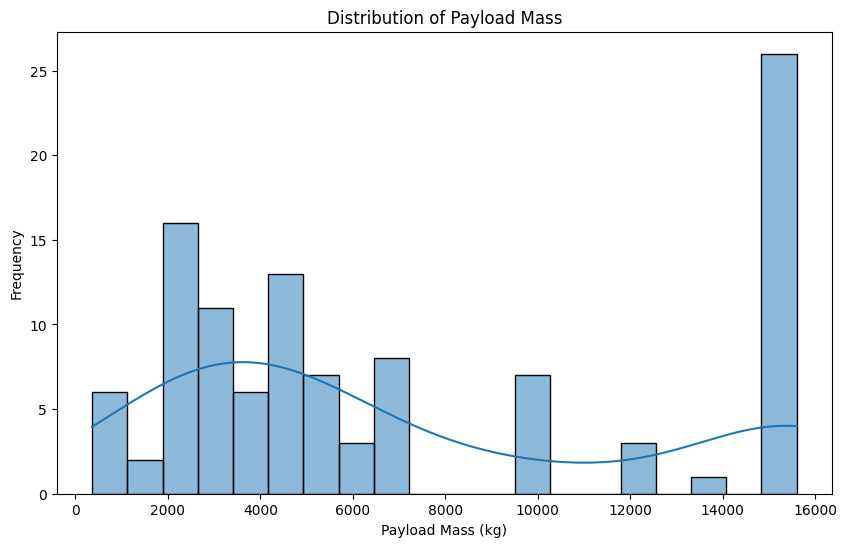

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Payload mass'], bins=20, kde=True)
plt.title('Distribution of Payload Mass')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Frequency')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The 'Payload mass' column was successfully cleaned by removing 'kg' and commas.
*   The cleaned 'Payload mass' column was converted to a numeric data type.
*   A histogram was generated to visualize the distribution of the 'Payload mass', showing the frequency of different payload mass ranges.

### Insights or Next Steps

*   The distribution plot provides an initial understanding of the typical range and spread of payload masses in the dataset. Further analysis could involve exploring the relationship between payload mass and other variables, such as launch success.
*   Consider calculating descriptive statistics (mean, median, standard deviation) for the 'Payload mass' to further quantify its distribution.
